# Control Run Analysis

Computation of the potential prognostic predictability (PPP) for metrics from the control simulation, eventually using pre-built functions in project folder. 

**Important metrics:** <br>
- SH sea ice extent/volume
- regional sea ice extent/volume
- regional NPP, PCO2, SSS, SST
- gridpoint-level fields for sea ice concentration, SST, SSS, NPP, PCO2 <-- *this is what I started with*
- sea ice edge position (latitude at which sea ice concentration drops below 15%)

**Steps:** <br>
- open dataset, including all files in control directory for specified variable
- compute climatology + rename variable (var --> var_clim)
- compute anomalies + rename variable (var --> var_anom)
- compute variance &emsp; $\sigma^{2}_{c} = \frac{\sum (X - \mu)^{2}}{N}$
    * mean of anomalies, by month
    * deviation of each anomaly data point, compared to monthly mean anomaly
    * square the deviations
    * sum the deviations, by month
    * divide these sums by number of years (300 in our case) <-- figure out how to keep NaN values, and stop conversion to 0s
- merge climatology, anomalies, variance, and original datasets (```compat = 'override'```)
- write this dataset to a NetCDF file

In [15]:
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore", message="Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range")
warnings.filterwarnings("ignore", message="invalid value encountered in reduce")

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

In [123]:
# compute the climatology (time mean for each month)
def compute_ctrl_clim(ds):
    return ds.groupby('time.month').mean(dim='time')


# # compute the monthly anomalies from the 300-year control runs
# def compute_ctrl_anom(ds):
#     clim = ds.groupby('time.month').mean(dim='time')

#     seq = []
#     for i in range(0,300):
#         seq.append(clim)

#     clim_full = xr.concat(seq, 'month')
#     clim_full = clim_full.assign_coords(month=ds.time.values)
#     clim_full = clim_full.rename({'month':'time'})

#     return (ds - clim_full)


# compute the monthly anomalies from the 300-year control runs
def compute_ctrl_anom(ds):
    clim = ds.groupby('time.month').mean(dim='time')
    return ds.groupby('time.month') - clim

# compute the variance of the anomalies for each month
# still working
def compute_ctrl_var(ds):
    continue

In [17]:
rootdir = '/local/projects/so_predict/esm2m_froelicher/'
subdir = 'CTRL'

In [226]:
ds = xr.open_mfdataset(rootdir+subdir+'/SST/sst_*.nc')

In [274]:
# function?
mean = compute_ctrl_anom(ds)

mean = ds.groupby('time.month').mean(dim='time')
dev = ds.groupby('time.month') - mean
dev2 = dev.assign(sst=dev.sst**2) # not sure how to make this part of a function due to the specific variable reference
dev2_sum = dev2.groupby('time.month').sum()

variance = dev2_sum.assign(sst=dev2_sum.sst / 300)
variance = variance.rename({'sst':'sst_var'})

In [285]:
d2 = dev2.rename({'sst':'dev2'})
d2_sum = dev2_sum.rename({'sst':'dev2_sum'})

ds.merge(variance, compat='override')

<xarray.Dataset>
Dimensions:     (month: 12, nv: 2, time: 3600, xt_ocean: 360, xu_ocean: 360, yt_ocean: 200, yu_ocean: 200)
Coordinates:
    geolat_c    (yu_ocean, xu_ocean) float32 dask.array<chunksize=(200, 360), meta=np.ndarray>
    geolat_t    (yt_ocean, xt_ocean) float32 dask.array<chunksize=(200, 360), meta=np.ndarray>
    geolon_c    (yu_ocean, xu_ocean) float32 dask.array<chunksize=(200, 360), meta=np.ndarray>
    geolon_t    (yt_ocean, xt_ocean) float32 dask.array<chunksize=(200, 360), meta=np.ndarray>
  * nv          (nv) float64 1.0 2.0
  * time        (time) object 0001-01-16 12:00:00 ... 0300-12-16 12:00:00
  * xt_ocean    (xt_ocean) float64 -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
  * xu_ocean    (xu_ocean) float64 -279.0 -278.0 -277.0 ... 78.0 79.0 80.0
  * yt_ocean    (yt_ocean) float64 -81.5 -80.5 -79.5 -78.5 ... 87.5 88.5 89.5
  * yu_ocean    (yu_ocean) float64 -81.0 -80.0 -79.0 -78.0 ... 88.0 89.0 90.0
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
    average_T1  (time) object dask.array<chunksize=(12,), meta=np.ndarray>
    average_T2  (time) object dask.array<chunksize=(12,), meta=np.ndarray>
    sst         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(12, 200, 360), meta=np.ndarray>
    time_bnds   (time, nv) timedelta64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    sst_var     (month, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 200, 360), meta=np.ndarray>
Attributes:
    filename:   ocean.000101-000512.sst.nc
    title:      ESM2M_pi-control_topaz_C3_verona_NEWDIAG_V4
    grid_type:  mosaic
    grid_tile:  1
    history:    Sun Dec 22 16:11:24 2019: ncks -4 -L 1 -a -O decadal_predicti...
    NCO:        netCDF Operators version 4.7.5 (Homepage = http://nco.sf.net,...

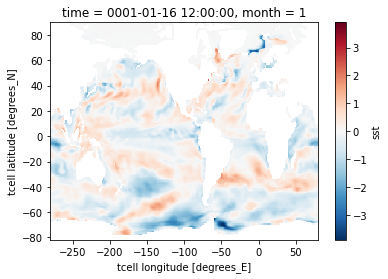

In [269]:
dev.sst[0].plot()

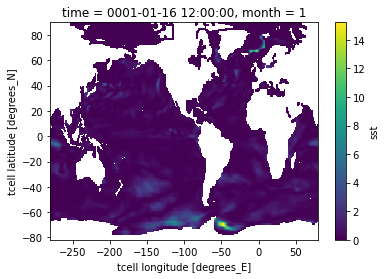

In [270]:
dev2.sst[0].plot()

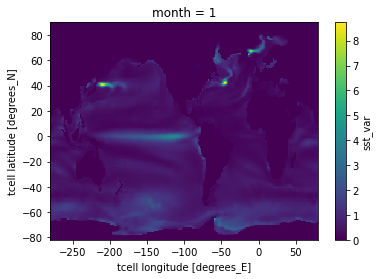

In [272]:
variance.sst_var[0].plot()

## Gridpoint-level Fields

#### Sea Surface Temperature (SST)

In [18]:
sst_ds = xr.open_mfdataset(rootdir+subdir+'/SST/sst_*.nc')

sst_clim = compute_ctrl_clim(sst_ds)
sst_clim = sst_clim.rename({'sst':'sst_clim'})

sst_anom = compute_ctrl_anom(sst_ds)
sst_ds = sst_ds.assign(anom=sst_anom['sst'])

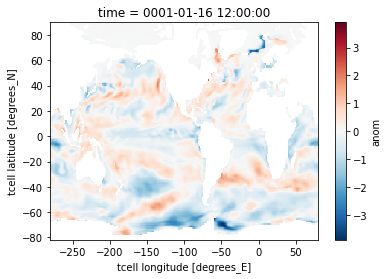

In [19]:
sst_ds.anom[0].plot()

#### Sea Surface Salinity (SSS)

In [20]:
sss_ds = xr.open_mfdataset(rootdir+subdir+'/SSS/sss_*.nc')

sss_clim = compute_ctrl_clim(sss_ds)
sss_clim = sss_clim.rename({'sss':'sss_clim'})

sss_anom = compute_ctrl_anom(sss_ds)
sss_ds = sss_ds.assign(anom=sss_anom['sss'])

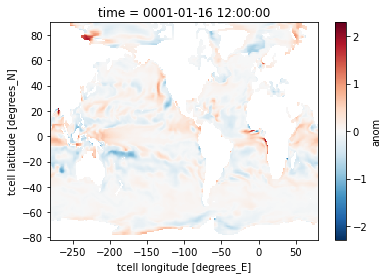

In [21]:
sss_ds.anom[0].plot()

#### Sea-ice Concentration (CN) summed over all thickness categories

In [22]:
cn_ds = xr.open_mfdataset(rootdir+subdir+'/CN/CN_inv_*.nc')
cn_ds = cn_ds.rename({'TIME':'time'})

cn_clim = compute_ctrl_clim(cn_ds)
cn_clim = cn_clim.rename({'CN_INV':'CN_CLIM'})

cn_anom = compute_ctrl_anom(cn_ds)
cn_ds = cn_ds.assign(ANOM=cn_anom['CN_INV'])
cn_ds = cn_ds.rename({'time':'TIME'})

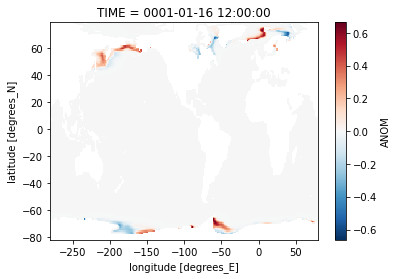

In [23]:
cn_ds.ANOM[0].plot()

#### Net Primary Production (NPP)

In [24]:
npp_ds = xr.open_mfdataset(rootdir+subdir+'/NPP/NPP_*.nc')
npp_ds = npp_ds.rename({'TIME':'time'})

npp_clim = compute_ctrl_clim(npp_ds)
npp_clim = npp_clim.rename({'NPP':'NPP_CLIM'})

npp_anom = compute_ctrl_anom(npp_ds)
npp_ds = npp_ds.assign(ANOM=npp_anom['NPP'])
npp_ds = npp_ds.rename({'time':'TIME'})

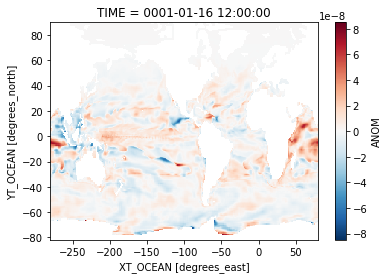

In [25]:
npp_ds.ANOM[0].plot()

#### Surface pCO$_2$ (PCO2)

In [26]:
pco2surf_ds = xr.open_mfdataset(rootdir+subdir+'/PCO2SURF/pco2surf_*.nc')

pco2surf_clim = compute_ctrl_clim(pco2surf_ds)
pco2surf_clim = pco2surf_clim.rename({'pco2surf':'pco2surf_clim'})

pco2surf_anom = compute_ctrl_anom(pco2surf_ds)
pco2surf_ds = pco2surf_ds.assign(anom=pco2surf_anom['pco2surf'])

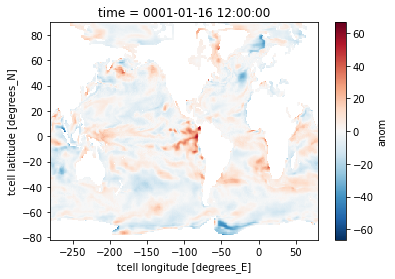

In [27]:
pco2surf_ds.anom[0].plot()